In [1]:
import torch
import torch.nn as nn # neural network yapısı
import torch.nn.functional as F # activation functions: relu, sigmoid etc.
import torch.utils.data as dt
import torch.optim as optim
from PIL import Image # python image lib for preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os # retrive images from folder
import time # calculate for algorithm running time
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

### NOTE
* Kodu CPU yerine GPU'da daha hızlı çalıştırmak için cuda indirilebiliriz. 
* Aşağıdaki kod satırı çalıştırılarak, **cpu** mu **gpu** mu varsayılan aygıt onu gösterir.
* Bunun için **cuda** yı internetten indirmek gerekir.
* Bu proje için **cuda** gerekli değil.

In [2]:
#%% device configuration OPTIONAL method: DEFAULT CPU but there is also GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## 1-Read Dataset

### NOTE:
Aşağıdaki return edilen array içerisinde:

0. indexinde 1x2048
1. indexinde 1x2048
2. indexinde 1x2048
   
   n. indexinde 1x.2048 tane veri olacaktır.

In [3]:
def read_images(path, num_img):
    array = np.zeros([num_img, 64*32]) # A 64x32 array containing *num_img* data is created, consisting of only 0's. (empty array)
    i = 0
    for img in os.listdir(path): # # loops through directory on given path on os.
        img_path = path + "\\" + img # path=C:\User...\neg + \\ + img=00000.png
        img = Image.open(img_path, mode = "r") # read and open image
        data = np.asarray(img, dtype = "uint8") # convert uint8 as array.
        data = data.flatten() # 64x32 => 1x2048 vectorial 
        array[i,:] = data # add data to row i and all columns in array.
        i += 1
    return array

### A) Read Train Negative(Nonpedestrian) Files
- Aşağıda kontrol amaçlı ilgili dizinde ilk 5 dosyanın gösterilmiştir.

In [4]:
with os.scandir('data/Train/neg') as entries:
    for index, entry in enumerate(entries):
        if(index<=5): #
            print(index, entry.name)
print("\nThere are {} images in the specified path.".format(index+1))

0 00000.png
1 00001.png
2 00002.png
3 00003.png
4 00004.png
5 00005.png

There are 43390 images in the specified path.


In [5]:
train_negative_path = r"data/Train/neg"
num_train_negative_img = index+1
train_negative_array = read_images(train_negative_path, num_train_negative_img)

In [6]:
print(train_negative_array[0][0])    # first index and first column
print(train_negative_array[0][2047]) # first index and last column

175.0
99.0


### NOTE
- Numpy'da array, torch'ta tensor kullanılır. 1D, 2D, 3D bunların genel ismi tensor'dur.

In [7]:
x_train_negative_tensor = torch.from_numpy(train_negative_array)
print("x_train_negative_tensor:", x_train_negative_tensor.size())
print(x_train_negative_tensor[0][0])    # first index and first column
print(x_train_negative_tensor[0][2047]) # first index and last column

x_train_negative_tensor: torch.Size([43390, 2048])
tensor(175., dtype=torch.float64)
tensor(99., dtype=torch.float64)


### NOTE
- **y_train**'de negativelere yani yaya olmayanlara 0 olarak label, class tanımlaması yaptık.

In [8]:
y_train_negative_tensor = torch.zeros(num_train_negative_img, dtype = torch.long)
print("y_train_negatice_tensor:", y_train_negative_tensor.size())

y_train_negatice_tensor: torch.Size([43390])


### B) Read Train Positive(Pedestrian) Files
- Aşağıda kontrol amaçlı ilgili dizinde ilk 5 dosyanın gösterilmiştir.

In [9]:
with os.scandir('data/Train/pos') as entries:
    for index2, entry in enumerate(entries):
        if(index2<=5): #
            print(index2, entry.name)
print("\nThere are {} images in the specified path.".format(index2+1))

0 00000.png
1 00001.png
2 00002.png
3 00003.png
4 00004.png
5 00005.png

There are 10208 images in the specified path.


### NOTE
- **y_train**'de positivelere yani yaya olanlara 1 olarak label, class tanımlaması yaptık.

In [10]:
train_positive_path = r"data/Train/pos"
num_train_positive_img = index2+1
train_positive_array = read_images(train_positive_path, num_train_positive_img) 

x_train_positive_tensor = torch.from_numpy(train_positive_array)
print("x_train_positive_tensor:", x_train_positive_tensor.size())

y_train_positive_tensor = torch.ones(num_train_positive_img, dtype = torch.long)
print("y_train_positive_tensor:", y_train_positive_tensor.size())

x_train_positive_tensor: torch.Size([10208, 2048])
y_train_positive_tensor: torch.Size([10208])


### C) Concat images in pos and neg folders.
### NOTE
- The **cat** function is called for concat in Pytorch.
- **Rows** are concatenated with **0** in the code block below.
- If it was 1 instead of **0**, the **columns** would be concatenated. 

In [11]:
x_train = torch.cat((x_train_negative_tensor, x_train_positive_tensor), 0)
y_train = torch.cat((y_train_negative_tensor, y_train_positive_tensor), 0)
print("x_train:", x_train.size())
print("y_train:", y_train.size())

x_train: torch.Size([53598, 2048])
y_train: torch.Size([53598])


### D) Read Test Negative(Nonpedestrian) Files
- Aşağıda kontrol amaçlı ilgili dizinde ilk 5 dosyanın gösterilmiştir.

In [12]:
with os.scandir('data/Test/neg') as entries:
    for index3, entry in enumerate(entries):
        if(index3<=5): #
            print(index3, entry.name)
print("\nThere are {} images in the specified path.".format(index3+1))

0 00000.png
1 00001.png
2 00002.png
3 00003.png
4 00004.png
5 00005.png

There are 22050 images in the specified path.


### NOTE
- **y_test**'de negative yani yaya olmayanlara 0 olarak label, class tanımlaması yaptık.

In [13]:
test_negative_path = r"data/Test/neg"
num_test_negative_img = index3+1
test_negative_array = read_images(test_negative_path, num_test_negative_img) 

x_test_negative_tensor = torch.from_numpy(test_negative_array)
print("x_test_negative_tensor:", x_test_negative_tensor.size())

y_test_negative_tensor = torch.ones(num_test_negative_img, dtype = torch.long)
print("y_test_negative_tensor:", y_test_negative_tensor.size())

x_test_negative_tensor: torch.Size([22050, 2048])
y_test_negative_tensor: torch.Size([22050])


### E) Read Test Positive(Pedestrian) Files
- Aşağıda kontrol amaçlı ilgili dizinde ilk 5 dosyanın gösterilmiştir.

In [14]:
with os.scandir('data/Test/pos') as entries:
    for index4, entry in enumerate(entries):
        if(index4<=5): #
            print(index4, entry.name)
print("\nThere are {} images in the specified path.".format(index4+1))

0 00000.png
1 00001.png
2 00002.png
3 00003.png
4 00004.png
5 00005.png

There are 5944 images in the specified path.


### NOTE
- **y_test**'de positivelere yani yaya olanlara 1 olarak label, class tanımlaması yaptık.

In [15]:
test_positive_path = r"data/Test/pos"
num_test_positive_img = index4+1
test_positive_array = read_images(test_positive_path, num_test_positive_img) 

x_test_positive_tensor = torch.from_numpy(test_positive_array)
print("x_test_positive_tensor:", x_test_positive_tensor.size())

y_test_positive_tensor = torch.ones(num_test_positive_img, dtype = torch.long)
print("y_test_positive_tensor:", y_test_positive_tensor.size())

x_test_positive_tensor: torch.Size([5944, 2048])
y_test_positive_tensor: torch.Size([5944])


### F) Concat images in pos and neg folders in Test.
### NOTE
- The **cat** function is called for concat in Pytorch.
- **Rows** are concatenated with **0** in the code block below.
- If it was 1 instead of **0**, the **columns** would be concatenated. 

In [16]:
x_test = torch.cat((x_test_negative_tensor, x_test_positive_tensor), 0)
y_test = torch.cat((y_test_negative_tensor, y_test_positive_tensor), 0)
print("x_test:", x_test.size())
print("y_test:", y_test.size())

x_test: torch.Size([27994, 2048])
y_test: torch.Size([27994])


### G) Visualize Data

### NOTE 
- If you are take error, for example, Kernel Died etc, so, you can install **conda install nomkl** command in terminal. 
- If it cannot be installed with this command, it is necessary to **remove** the **mkl package**. 

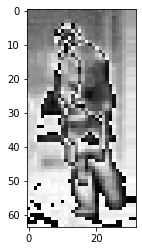

In [17]:
plt.imshow(x_train[45000, :].reshape(64, 32), cmap = "gray")
plt.show()

## 2-Create DRN Model

### A) Defining Hyperparameters

53598 tane train verisi var, bu sayının bölenleri:
- 1
- 2
- 3
- 6
- **8933** bu seçildi.
- 17866
- 26799
- 53598
Batch_size train için seçilecektir.

27994 tane test verisi var, bu sayının bölkenleri:
- 1
- 2
- **13997** bu seçildi.
- 27994

test için farklı bunlardan biri seçilir. Memory'ye göre seçilmelidir.

In [18]:
num_epochs = 10
num_classes = 2
batch_size = 8933 #train # veri seti size / batch size => kalan 0 olmalı
batch_size_t = 13997 #test # veri seti size / batch size => kalan 0 olmalı
learning_rate = 0.00001

### B) Merge x and y train/test tensors and convert data

In [19]:
train = dt.TensorDataset(x_train, y_train) # merge x_train and y_train
trainloader = dt.DataLoader(train, batch_size = batch_size, shuffle = True) # train, convert to data.

test = dt.TensorDataset(x_test, y_test) # merge x_test and y_test
testloader = dt.DataLoader(test, batch_size = batch_size_t, shuffle = False)

### C) Define Convolotional Layers

In [20]:
# kernel_size = 3x3
# input_channels = 3 => rgb, 1 => gray
# output_channels = 10 => layerdaki nöron sayısı
# stride = 1 => Filter 1'er 1'er dolaşacak.
# padding = 1 => input resmin etrafına 0'lar eklenir, size korunur. 
def conv3x3(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 3, stride = stride, padding = 1, bias = False)

# kernel_size = 1x1
def conv1x1(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 1, stride = stride, bias = False)

### D) Create Basic Block

### NOTE
- input da tutulduğu için, input yani idendity (x) en son toplanır ve reluya diğer out ile birlikte gönderilir. Yani:
- x => conv1 => bn1 => relu => dropout => conv2 => bn2 => odwnsample => stride = **out** iken,
- out + idendity(input) = ile son bir relu'ya işleme koyarız.

In [21]:
class BasicBlock(nn.Module): # Tüm Neural Network modüllerini inherit eder.
    
    expansion = 1
    
    def __init__(self, inplanes, outplanes, stride = 1, downsample = None):
        super(BasicBlock, self).__init__() # nn.Module'u inherit edilir.
        self.conv1 = conv3x3(inplanes, outplanes, stride)
        self.bn1 = nn.BatchNorm2d(outplanes) # her layerda normalization yapılır.
        self.relu = nn.ReLU(inplace = True)
        self.drop = nn.Dropout(0.9)
        self.conv2 = conv3x3(outplanes, outplanes)
        self.bn2 = nn.BatchNorm2d(outplanes)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x): # layerları birbirlerine bağlar
        identity = x # idendity=shortcut=x.  
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.drop(out)
        
        if self.downsample is not None: # if stride != 1,
            identity = self.downsample(x)
            
        out += identity # input=idendity=x relu 
        out = self.relu(out)
        return out

### E) Create RestNet Class

In [22]:
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes = num_classes):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride = 2, padding = 3, bias= False) # stride=2 => downsampling
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size= 3, stride = 2, padding = 1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride = 2)
    
        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # average=> output 1,1 olsun diyoruz.
        self.fc = nn.Linear( 256 * block.expansion, num_classes)

        # update weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # conv layerındaysa
                # Yalnızca 0'a yakın sayıları weighte initiliaze ediyor.
                nn.init.kaiming_normal_(m.weight, mode = "fan_out", nonlinearity = "relu")
            elif isinstance(m, nn.BatchNorm2d): # batch layerındaysa
                nn.init.constant_(m.weight, 1) # tüm weightleri 1 yap
                nn.init.constant_(m.bias, 0) # bias 0 yapılır

    # amaç basic_blockları(2 tane block) oluştururak ard arada bir layer oluşturmak
    # block=BasicBlock
    # blocks=2 için 2 tane bloku ard arda bağlayacak.        
    def _make_layer(self, block, input_channels, blocks, stride = 1):
        downsample = None # başlangıçta none
        if stride != 1 or self.inplanes != input_channels * block.expansion:
            downsample = nn.Sequential(
                    conv1x1(self.inplanes, input_channels*block.expansion, stride),
                    nn.BatchNorm2d(input_channels * block.expansion)) # her zaman 1 geliyor, göz ardı edebiliriz.
        layers = []
        layers.append(block(self.inplanes, input_channels, stride, downsample)) # default  olarak 1 block ekledik.
        self.inplanes = input_channels * block.expansion # expansion=1, return 1

        # kullanılmayacağı zaman _ koyabiliriz.
        for _ in range(1, blocks): #1 den başlattık, çünkü yukarıda zaten 1 tane append yaptık.
            layers.append(block(self.inplanes, input_channels))
        
        return nn.Sequential(*layers) # hepsini alabilmesi için * koyarız ve arda arda layerları dizecek tüm layerlerı 1 layer yapacak.
        
    #sequantial path
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1) # x.size/2 and -1 => kendisi hesaplayıp söyleyecek, ne olduğu önemli değil.
        x = self.fc(x)
        
        return x

### F) Create Model and criterion and optimizer

### NOTE
- GPU aktif edildiyse **model = ResNet(BasicBlock, [2,2,2]).to(device)** run edilerek GPU'da işlemler hızlı bir şekilde gerçekleştirilir.

In [23]:
model = ResNet(BasicBlock, [2,2,2])  # Crete DRN Model with 2 blocks 
# model = ResNet(BasicBlock, [2,2,2]).to(device) # for GPU

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

## 3) Train Data

### A) Define Basic Variables

In [25]:
start = time.time()
train_acc = []
test_acc = []
loss_list = [] # total error (kayıp)
use_gpu = False # True # if we use GPU
total_step = len(trainloader)

In [26]:
for epoch in range(num_epochs): # 100 kez train edilecek.
    for i, (images, labels) in enumerate(trainloader, 0):
       
        # images = inputs , labels = 0 or 1
        images = images.view(batch_size, 1, 64, 32) # view=reshape, 1=color channel
        images = images.float() # convert float
        
        # use gpu
        if use_gpu:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)

        outputs = model(images) #forward (inputs => outputs)
        
        loss = criterion(outputs, labels) # loss (compare outputs vs labels)
        
        # backward and optimization
        optimizer.zero_grad() # zero gradient (türevler her adımda 0'lanmalı)
        loss.backward() # back (finding gradient)
        optimizer.step() # update weights

        if i % 2 == 0: # ekrranda ne kadar sık görmek istiyoruz.
            print("epoch: {} {}/{}".format(epoch, i, total_step))
    
    # train
    correct = 0 # correct predict
    total = 0 # total data
    with torch.no_grad(): # back propagation'u kapatıyoruz(train bitti)
        for data in trainloader:
            images, labels = data
            images = images.view(batch_size, 1, 64, 32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
                    
            outputs = model(images) # outputlar doğru mu yanlış mı acaba?
            _, predicted = torch.max(outputs.data,1) # maximum olanlar predictlerin indexini verir.
            total += labels.size(0) # toplamımız size'a eşit olacak
            correct += (predicted == labels).sum().item() # for int value we use item()
        
    print("Accuracy train %d %%"%(100 * correct / total))
    train_acc.append(100 * correct / total)

    # test
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(batch_size_t, 1, 64, 32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
                    
            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy test %d %%"%(100*correct/total))
    train_acc.append(100 * correct /  total)

    loss_list.append(loss.item())

epoch: 0 0/6
epoch: 0 2/6
epoch: 0 4/6
Accuracy train 69 %
Accuracy test 18 %
epoch: 1 0/6
epoch: 1 2/6
epoch: 1 4/6
Accuracy train 70 %
Accuracy test 17 %
epoch: 2 0/6
epoch: 2 2/6
epoch: 2 4/6
Accuracy train 71 %
Accuracy test 15 %
epoch: 3 0/6
epoch: 3 2/6
epoch: 3 4/6
Accuracy train 72 %
Accuracy test 14 %
epoch: 4 0/6
epoch: 4 2/6
epoch: 4 4/6
Accuracy train 72 %
Accuracy test 14 %
epoch: 5 0/6
epoch: 5 2/6
epoch: 5 4/6
Accuracy train 72 %
Accuracy test 12 %
epoch: 6 0/6
epoch: 6 2/6
epoch: 6 4/6
Accuracy train 73 %
Accuracy test 12 %
epoch: 7 0/6
epoch: 7 2/6
epoch: 7 4/6
Accuracy train 73 %
Accuracy test 11 %
epoch: 8 0/6
epoch: 8 2/6
epoch: 8 4/6
Accuracy train 74 %
Accuracy test 11 %
epoch: 9 0/6
epoch: 9 2/6
epoch: 9 4/6
Accuracy train 74 %
Accuracy test 10 %


In [27]:
print("train is done.")

end = time.time()
process_time = (end - start) / 60
print("process time: ", process_time)

train is done.
process time:  70.25288607676823


## 4-Visualize Data

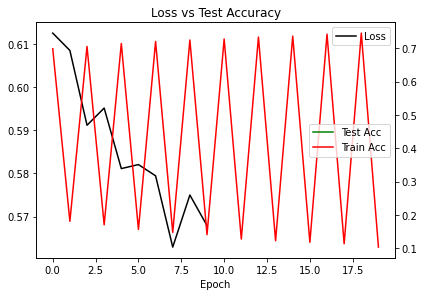

In [28]:
#%% visualize

fig, ax1 = plt.subplots()
plt.plot(loss_list,label = "Loss",color = "black")
ax2 = ax1.twinx()
ax2.plot(np.array(test_acc)/100,label = "Test Acc",color="green")
ax2.plot(np.array(train_acc)/100,label = "Train Acc",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
fig.tight_layout()
plt.title("Loss vs Test Accuracy")
plt.show()